In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import io, filters 
from skimage.filters import threshold_otsu
from skimage.morphology import binary_opening, binary_closing, disk

In [62]:
# Instala las librerías si aún no lo has hecho
# !pip install pystac-client stackstac xarray matplotlib planetary-computer

import pystac_client
import stackstac
import xarray as xr
import matplotlib.pyplot as plt
import planetary_computer as pc # Importante para autenticar el acceso a los datos
from datetime import datetime

In [44]:
# Conecta con la API STAC de Microsoft Planetary Computer
CATALOG_URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
# Usa pc.sign_inplace para firmar los items correctamente y evitar el warning
catalog = pystac_client.Client.open(CATALOG_URL, modifier=pc.sign_inplace)

In [47]:
# Define tus parámetros de búsqueda
# Ejemplo de AOI (Cuadro delimitador: [min_lon, min_lat, max_lon, max_lat])
# bbox Barcelona, España
bbox = [-74.30, 4.45, -73.90, 4.85] 

#bbox = [-74.3, 4.45, -73.9, 4.85]
# Rango de fechas
time_range = "2024-06-01/2025-06-30"

# Filtro de metadatos (ej: cobertura de nubes menor al 10%)
# La colección de Sentinel-2 Nivel 2A es 'sentinel-2-l2a'
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=time_range,
    query={"eo:cloud_cover": {"lt": 10}}, # Cubierta de nubes < 10%
)

# Obtener los resultados (STAC Items)
items = search.get_all_items()
print(f"Número de imágenes encontradas: {len(items)}")

Número de imágenes encontradas: 2


In [53]:
# Bandas a cargar: usaremos una sola banda (NIR, B08, 10 m) como "pancromática"
bands = ["B04", "B08"]

# Para no descargar toda la serie temporal, nos quedamos solo con la primera imagen
items_one = items[:1]

# Usar stackstac para crear un array de datos (DataArray)
data_array = stackstac.stack(
    items_one,
    assets=bands,
    chunksize=4096,  # Tamaño de fragmento para un manejo eficiente de la memoria
    epsg=3857,      # Proyectar a Web Mercator
    fill_value=0    # Valor para NoData (el fondo)
)

print(data_array)

<xarray.DataArray 'stackstac-5c61816c164f0147ce5db2df93cd0190' (time: 1,
                                                                band: 2,
                                                                y: 10981,
                                                                x: 10981)> Size: 2GB
dask.array<fetch_raster_window, shape=(1, 2, 10981, 10981), dtype=float64, chunksize=(1, 1, 4096, 4096), chunktype=numpy.ndarray>
Coordinates: (12/45)
  * time                                     (time) datetime64[ns] 8B 2025-01...
    id                                       (time) <U54 216B 'S2A_MSIL2A_202...
  * band                                     (band) <U3 24B 'B04' 'B08'
  * x                                        (x) float64 88kB -8.249e+06 ... ...
  * y                                        (y) float64 88kB 6.051e+05 ... 4...
    s2:high_proba_clouds_percentage          float64 8B 1.185
    ...                                       ...
    proj:bbox                       

In [54]:
# Extracción de las bandas por su nombre de asset
red = data_array.sel(band="B04")
nir = data_array.sel(band="B08")

# Aplicar la fórmula NDVI: (NIR - RED) / (NIR + RED)
# Se usa np.clip para manejar divisiones por cero y asegurar el rango
ndvi = (nir - red) / (nir + red) 

print("\nCálculo de NDVI completado.")


Cálculo de NDVI completado.


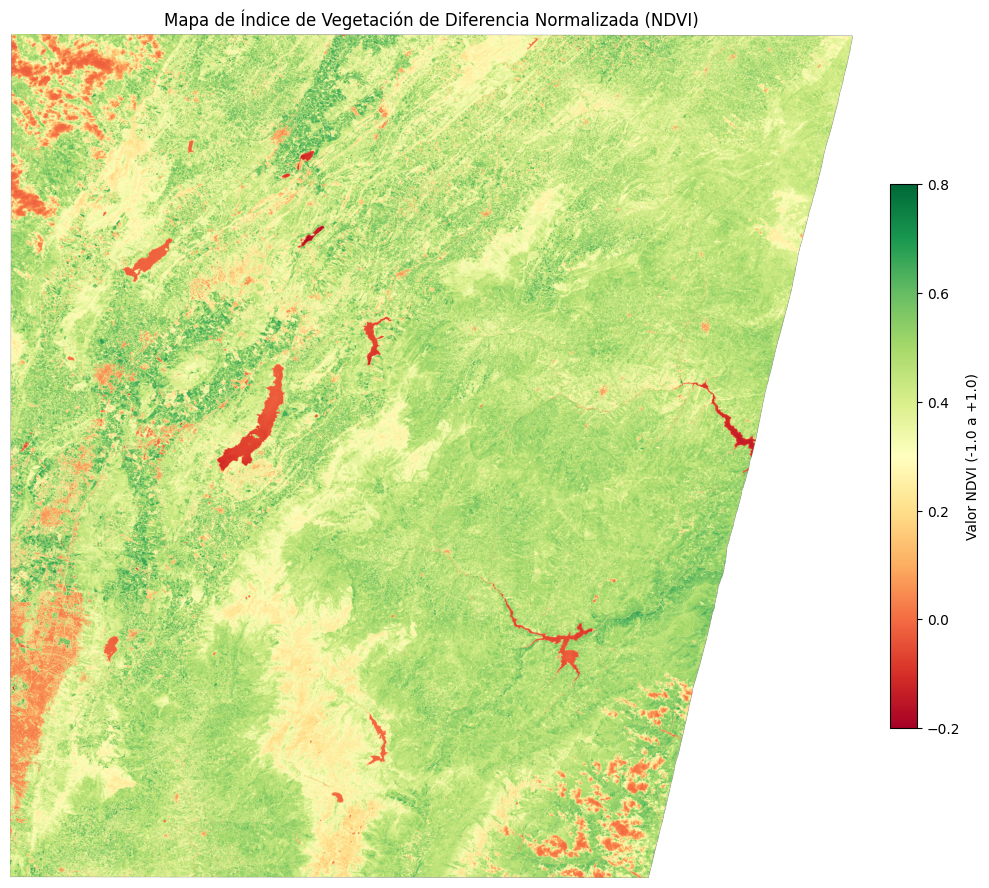

In [56]:
# --- Visualización de la Imagen NDVI (Sola) ---

# Obtén los datos NDVI como un array numpy para visualización
ndvi_np = ndvi.squeeze().values  # elimina dimensiones de longitud 1 (ej: 'time','band')

# Crea la figura y los ejes para la visualización
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Muestra la imagen NDVI
# Utilizamos un mapa de colores 'RdYlGn' (Rojo-Amarillo-Verde) 
# para que el verde oscuro represente la vegetación alta.
# Definimos vmin y vmax para estandarizar la escala entre -0.2 y 0.8.
im = ax.imshow(
    ndvi_np, 
    cmap='RdYlGn', 
    vmin=-0.2, 
    vmax=0.8
)

# Configuración del título y ejes
ax.set_title('Mapa de Índice de Vegetación de Diferencia Normalizada (NDVI)')
ax.axis('off')

# Añadir barra de color (colorbar) para interpretar los valores
cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Valor NDVI (-1.0 a +1.0)')

plt.tight_layout()
plt.show()

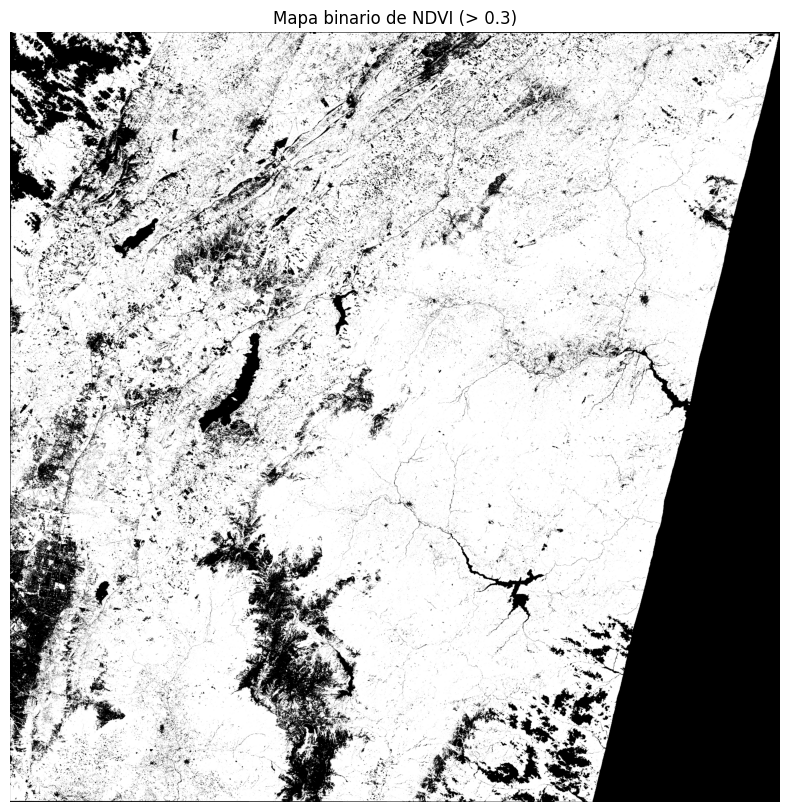

In [ ]:
#1. Threshold a grayscale or panchromatic/NDVI image or consider a binary land cover map.


#umbral
UMBRAL_NDVI = 0.3 # Puedes experimentar con 0.25 o 0.35 si es necesario

# Aplication
binary_map_ndvi = ndvi.squeeze() > UMBRAL_NDVI

# Convertir a numpy array para la morfología posterior (dtype=bool)
binary_map_np = binary_map_ndvi.values 

plt.figure(figsize=(10, 10))
plt.imshow(binary_map_np, cmap='gray')
plt.title("Mapa binario de NDVI (> 0.3)")
plt.axis('off')
plt.show()

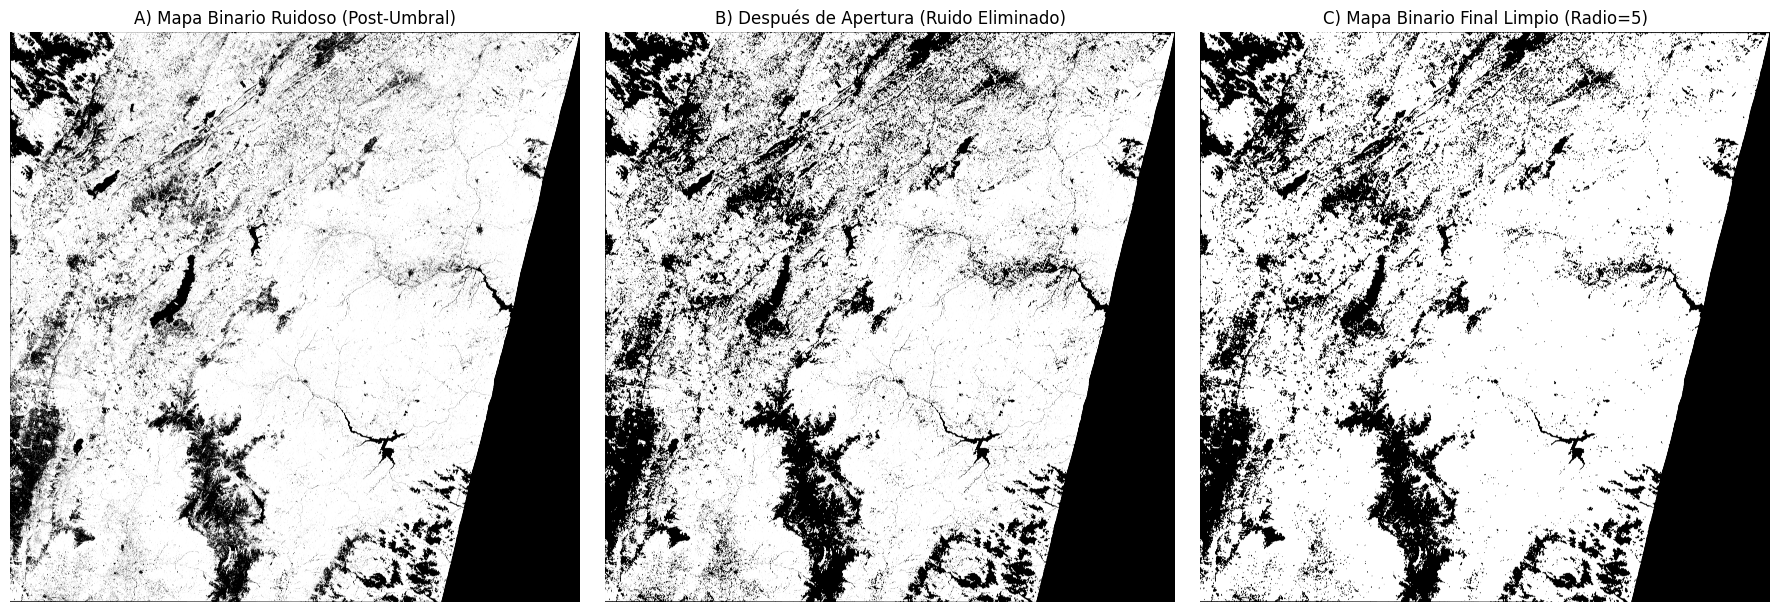

In [66]:
# 2. Compare the effect of erosion, dilation, opening, closing with different structuring elements.

# Nota: en versiones recientes de scikit-image, el parámetro 'selem' se ha reemplazado por 'footprint'.
# create a structuring element
SELEM_SIZE = 5  
selem = disk(SELEM_SIZE)

# A. Apertura (Opening): Elimina pequeñas islas de ruido (speckles) 
# 
opened_map = binary_opening(binary_map_np, footprint=selem)

# B. Cierre (Closing): Rellena pequeños huecos dentro de las áreas grandes 
# 
final_vegetation_map = binary_closing(opened_map, footprint=selem)

# --- Paso 3: Visualización de los Resultados ---

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Mapa Binario Inicial (Ruidoso)
axes[0].imshow(binary_map_np, cmap='gray')
axes[0].set_title('A) Mapa Binario Ruidoso (Post-Umbral)')
axes[0].axis('off')

# 2. Mapa después de la Apertura
axes[1].imshow(opened_map, cmap='gray')
axes[1].set_title(f'B) Después de Apertura (Ruido Eliminado)')
axes[1].axis('off')

# 3. Mapa Final (Limpio)
axes[2].imshow(final_vegetation_map, cmap='gray')
axes[2].set_title(f'C) Mapa Binario Final Limpio (Radio={SELEM_SIZE})')
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#3. Apply the more advanced morphological operators on the image.